# Test on the Voronoi Statistics 

#### (Figure 2)

We apply the 3 Voronoi tests we developed, to use on 34 samples grown in natural environment. We access the test performance of hydathode and veins, against the 3 reference point sets.

In [27]:
import io
import sys

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from statannot import add_stat_annotation
from matplotlib.collections import LineCollection
from scipy.spatial import Voronoi

# bayesian inference modules
import bambi as bmb 
import arviz as az

# load local modules
sys.path.insert(0, '../') 
import graph_create, voronoi_local, jaccard_similarity, center_predict


-------

## Read in all sample graphs from the control condition

In [28]:
dot_folder = f'../data/natural/natural_dots_all'
vein_folder = f'../data/natural/natural_txt_all'
samples = pd.read_csv('../data/natural/natural_all.csv', delimiter=',', header = None)
sample_list = samples[0].tolist()

In [29]:
def shape_dfs(data_arr, value_name = 'error'):
    
    'helper function to make dataframe'
    
    mean_df = pd.DataFrame(data_arr, index = sample_list, columns = ['hydathode','centroid','mid-point','random'])
    mean_df['plant'] = samples[1].tolist()
    mean_df['sample'] = mean_df.index

    melted_mean_df = mean_df.melt(id_vars= ['sample', 'plant'] , var_name='type', value_name= value_name)
    melted_mean_df["type"]  = pd.Categorical(melted_mean_df["type"].tolist(), categories = ['hydathode','centroid','mid-point','random'], ordered=True)

    return mean_df, melted_mean_df

-------

## Voronoi I Test

In [30]:
angle_mean_arr = np.zeros([34,4])
dist_mean_arr = np.zeros([34,4])

In [31]:
def local_error(sample):

    'helper function to streamline the Voronoi I test for a single sample'
    
    G = graph_create.graph_creation(sample, dot_folder= dot_folder, vein_folder = vein_folder)

    ######  Comment the below lines to track the testing process! #############
    # create a text trap and redirect stdout
    text_trap = io.StringIO()
    sys.stdout = text_trap
    ###########################################################################

    print('Perform local tests... \n')
    # local tests:
    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)

    # baseline local tests:
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)    
    centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
    midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
    random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

    _ = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])

    baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

    angle_list = [baseline_summary['angle_mean'][0],
                        baseline_summary['angle_mean'][1],
                        baseline_summary['angle_mean'][2],
                        baseline_summary['angle_mean'][3]]

    dist_list = [baseline_summary['dist_mean'][0],
                        baseline_summary['dist_mean'][1],
                        baseline_summary['dist_mean'][2],
                        baseline_summary['dist_mean'][3]]

    print('Local tests done! \n')

    ######  Comment the below lines to track the testing process! #############
    # now restore stdout function
    sys.stdout = sys.__stdout__
    ###########################################################################

    return angle_list, dist_list, rst[1].shape[0], len(G.graph['dots_passed'])


In [32]:
for i, sample in enumerate(sample_list):
    angle_list, dist_list, num_pair, num_face = local_error(sample)
    angle_mean_arr[i] = angle_list
    dist_mean_arr[i] = dist_list

../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


In [33]:
_, melted_angle_mean_df = shape_dfs(angle_mean_arr, value_name = 'error')

#### Bayesian Linear Mixed Effects Models

Since all leaf samples we use comes from 6 plants, different plants might contribute to the varibilities in Voronoi statistics.

Therefore, we introduce plant as a variable in potentially explaining the variations in the Voronoi test performance. We choose to use Bayesian Linear Mixed Effects Models to distangle the random effects (called `Group-level effects` in the model description) coming from plants.

We will use this approach for all Voronoi I-III tests.

In [34]:
# Bayesian mixture model
angle_model= bmb.Model("error ~ type + (1|plant)", melted_angle_mean_df, dropna=True, categorical = "type")
angle_model

Formula: error ~ type + (1|plant)
Family name: Gaussian
Link: identity
Observations: 136
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 12.0552, sigma: 17.7477)
    type ~ Normal(mu: [0. 0. 0.], sigma: [28.9818 28.9818 28.9818])

  Group-level effects
    1|plant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 17.7477))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 5.0198)

In [35]:
angle_results =angle_model.fit(chains=5, draws=2000)

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 61 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6725, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6405, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6926, but should be close to 0.8. Try to increase the number of tuning steps.


In [36]:
az.summary(angle_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.255,0.442,7.413,9.070,0.012,0.008,1759.0,1572.0,1.00
type[centroid],1.119,0.464,0.263,1.998,0.009,0.007,2910.0,657.0,1.00
type[mid-point],2.425,0.471,1.610,3.389,0.010,0.008,2463.0,697.0,1.00
type[random],11.752,0.469,10.864,12.646,0.010,0.007,2397.0,836.0,1.00
1|plant_sigma,0.609,0.434,0.005,1.285,0.020,0.019,1019.0,750.0,1.01
error_sigma,1.882,0.121,1.659,2.112,0.002,0.001,4547.0,4736.0,1.00
1|plant[1],0.243,0.405,-0.458,1.090,0.009,0.007,2164.0,2156.0,1.00
1|plant[2],0.464,0.449,-0.295,1.344,0.009,0.006,2709.0,2222.0,1.00
1|plant[3],-0.363,0.445,-1.334,0.322,0.011,0.008,1909.0,1865.0,1.00
1|plant[4],-0.156,0.424,-1.004,0.656,0.014,0.014,1336.0,567.0,1.00


#### Plot the inferred mean and 95% confidence interval:

In [37]:
slopes = angle_results.posterior.type.values
intercept = angle_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1)) 

In [38]:
# set plotting colors scheme for plotting 
sns.color_palette("rocket_r")
sns.set_style("white")
order = ['hydathode', 'centroid', 'mid-point', 'random']
colors = ['chocolate', np.atleast_2d(sns.color_palette("rocket_r")[3]), np.atleast_2d(sns.color_palette("rocket_r")[4]), np.atleast_2d(sns.color_palette("rocket_r")[5])]
palette = dict(zip(order, colors))

In [39]:
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

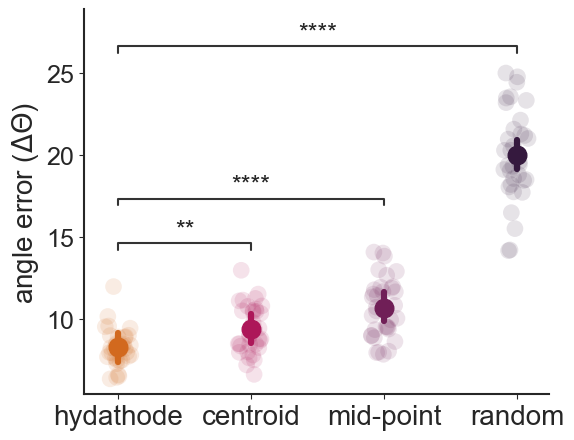

In [40]:
# plotting the subfigure for Voronoi I- angle error:
fig, ax = plt.subplots(figsize = (6,5))

sns.stripplot (x = 'type', y = 'error', data = melted_angle_mean_df, order = order, 
               palette = palette,
               alpha = .12, size = 12, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_angle_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 18)

# add foreground inferred information
x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(angle_results)['mean']['Intercept'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[centroid]'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[mid-point]'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[random]']]

for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 4.5)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 180, zorder = 2)

    
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 20)
ax.set_xlabel(None)
ax.set_ylabel('angle error ($\Delta \Theta$) ', fontsize = 20)
ax.set_yticks([10, 15, 20, 25])
ax.set_yticklabels(labels = [10, 15, 20, 25], fontsize = 18)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.setp(ax.spines.values(), linewidth=1.5)


plt.show()

In [41]:
_, melted_dist_mean_df = shape_dfs(dist_mean_arr, value_name = 'error')

In [42]:
dist_model= bmb.Model("error ~ type + (1|plant)", melted_dist_mean_df, dropna=True, categorical = "type")
dist_results =dist_model.fit(chains=5, draws=2000)

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 68 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [43]:
az.summary(dist_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.130,0.006,0.118,0.141,0.0,0.0,3456.0,3042.0,1.0
type[centroid],0.084,0.008,0.069,0.098,0.0,0.0,5631.0,6667.0,1.0
type[mid-point],0.109,0.008,0.095,0.124,0.0,0.0,6043.0,6623.0,1.0
type[random],0.274,0.008,0.260,0.289,0.0,0.0,5895.0,6273.0,1.0
1|plant_sigma,0.005,0.004,0.000,0.012,0.0,0.0,2741.0,3178.0,1.0
error_sigma,0.032,0.002,0.028,0.035,0.0,0.0,7826.0,6267.0,1.0
1|plant[1],0.001,0.004,-0.007,0.010,0.0,0.0,4784.0,3937.0,1.0
1|plant[2],-0.001,0.004,-0.010,0.007,0.0,0.0,5639.0,4670.0,1.0
1|plant[3],0.001,0.004,-0.008,0.009,0.0,0.0,5251.0,5548.0,1.0
1|plant[4],0.002,0.005,-0.006,0.012,0.0,0.0,4902.0,4361.0,1.0


In [44]:
slopes = dist_results.posterior.type.values
intercept = dist_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [45]:
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

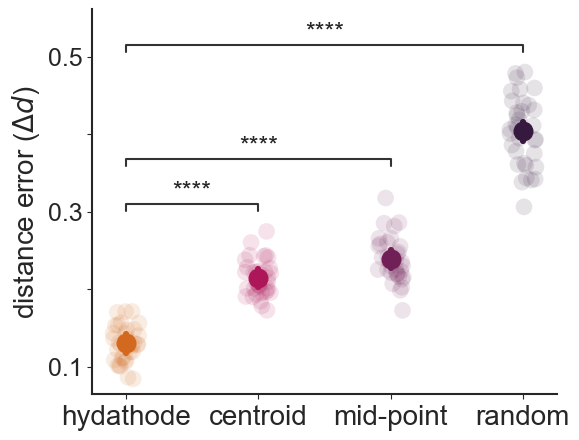

In [46]:
# plotting the subfigure for Voronoi I- distance error:

fig, ax = plt.subplots(figsize = (6,5))

sns.stripplot (x = 'type', y = 'error', data = melted_dist_mean_df, order = order, 
               palette = palette,
               alpha = .12, size = 12, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_dist_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 18)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(dist_results)['mean']['Intercept'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[centroid]'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[mid-point]'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 4.5)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 180, zorder = 2)

    
# ax.set_title('Voronoi I: angle test (n = 34)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 20)
ax.set_xlabel(None)
ax.set_ylabel('distance error ($\Delta d$)', fontsize = 20)
ax.set_yticks([.1, .2, .3, .4, .5])
ax.set_yticklabels(labels = [.1, None, .3, None, .5], fontsize = 18)


# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.spines.values(), linewidth=1.5)

plt.show()

-------

## Voronoi II test

In [47]:
J_mean_arr = np.zeros([34,4])

In [48]:
def spatial_overlap(sample):
    
    'helper function to streamline the Voronoi II test for a single sample'

    G = graph_create.graph_creation(sample, dot_folder= dot_folder, vein_folder= vein_folder)

    seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
    vor = Voronoi(seeds)
    bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
    J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions)

    ######  Comment the below lines to track the testing process! #############
    # create a text trap and redirect stdout
    text_trap = io.StringIO()
    sys.stdout = text_trap
    ###########################################################################

    print(f'start area test for {sample}  \n')


    centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

    centroid_vor = Voronoi(centroid_seeds)
    midpoint_vor =  Voronoi(midpoint_seeds)
    random_vor = Voronoi(random_seeds)

    centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
    midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
    random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

    centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions)
    midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions)
    random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions)

    print(f'Finish area test. \n')

    ######  Comment the below lines to track the testing process! #############
    # now restore stdout function
    sys.stdout = sys.__stdout__
    ###########################################################################

    return J_list.mean(), centroid_J_list.mean(), midpoint_J_list.mean(), random_J_list.mean()

In [49]:
for i, sample in enumerate(sample_list):
    J_mean_arr[i] = spatial_overlap(sample)

../jaccard_similarity.py:318: RuntimeWarning: invalid value encountered in true_divide
  J_list = shared_area_list/union_area_list


In [50]:
_, melted_J_mean_df = shape_dfs(J_mean_arr, value_name = 'error')

In [51]:
# Bayesian mixture model
J_model= bmb.Model("error ~ type + (1|plant)", melted_J_mean_df, dropna=True, categorical = "type")
J_results =J_model.fit(chains=5, draws=2000)

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 58 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6608, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [52]:
J_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [53]:
az.summary(J_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.716,0.007,0.703,0.729,0.0,0.0,3080.0,2911.0,1.0
type[centroid],-0.051,0.007,-0.064,-0.038,0.0,0.0,5888.0,6320.0,1.0
type[mid-point],-0.080,0.007,-0.093,-0.067,0.0,0.0,4887.0,4474.0,1.0
type[random],-0.252,0.007,-0.265,-0.238,0.0,0.0,5678.0,4449.0,1.0
1|plant_sigma,0.011,0.007,0.000,0.023,0.0,0.0,1683.0,1877.0,1.0
error_sigma,0.029,0.002,0.026,0.033,0.0,0.0,5502.0,4701.0,1.0
1|plant[1],0.002,0.007,-0.010,0.015,0.0,0.0,3778.0,3786.0,1.0
1|plant[2],-0.004,0.007,-0.018,0.009,0.0,0.0,4209.0,4211.0,1.0
1|plant[3],0.013,0.008,-0.001,0.028,0.0,0.0,3054.0,3629.0,1.0
1|plant[4],-0.004,0.007,-0.017,0.008,0.0,0.0,3623.0,3808.0,1.0


In [54]:
slopes = J_results.posterior.type.values
intercept = J_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [55]:
pvalues = [(slopes[:,:,0] >= 0).sum()/10000, (slopes[:,:,1] >= 0).sum()/10000, (slopes[:,:,2] >= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

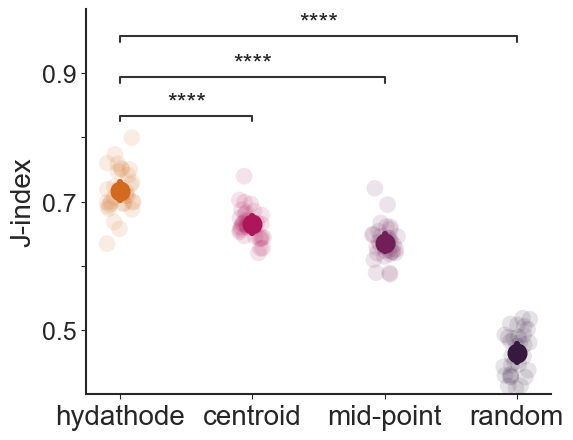

In [56]:
# plotting the subfigure for Voronoi II overlap:

fig, ax = plt.subplots(figsize = (6,5))

sns.stripplot (x = 'type', y = 'error', data = melted_J_mean_df, order = order, 
               palette = palette,
               alpha = .12, size = 12, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_J_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 18)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(J_results)['mean']['Intercept'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[centroid]'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[mid-point]'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 4.5)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 180, zorder = 2)

    
# ax.set_title('Voronoi I: angle test (n = 34)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 20)
ax.set_xlabel(None)
ax.set_ylabel('J-index', fontsize = 20)
ax.set_yticks([.5, .6, .7,.8, .9])
ax.set_yticklabels(labels = [.5, None, .7, None, .9], fontsize = 18)

ax.set_ylim((0.4, 1))

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.setp(ax.spines.values(), linewidth=1.5)

plt.show()


-------

## Voronoi III test

In [57]:
predict_err_arr = np.zeros([34,4])

In [58]:
def center_error_gcc_best(sample):
    
    'helper function to streamline the Voronoi II test for a single sample'

    ######  Comment the below lines to track the testing process! #############
    # create a text trap and redirect stdout
    text_trap = io.StringIO()
    sys.stdout = text_trap
    ###########################################################################

    print(f'Predict center for {sample}  \n')

    G = graph_create.graph_creation(sample, dot_folder, vein_folder)

    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)
    G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
    _, _, g_list, g_nodes_index = center_predict.slope_intercept_gcc(G, G_dual, shared_edges_mat, test_type= 'best')
    
    cent_list = [cent_in_faces[g_nodes_index[node]] for node in g_list]
    mid_list = [mid_in_faces[g_nodes_index[node]] for node in g_list ]
    rand_list = [rand_in_faces[g_nodes_index[node]] for node in g_list ]

    greatest_dual =  G_dual.subgraph(max(nx.connected_components(G_dual), key=len))
    
    mean_dist_rand, _ = center_predict.random_all(G, G_dual, greatest_dual, shared_edges_mat, g_list, g_list)
    cent_dist_rand, _ = center_predict.random_all(G, G_dual, greatest_dual, shared_edges_mat, g_list, cent_list)
    mid_dist_rand, _ = center_predict.random_all(G, G_dual, greatest_dual, shared_edges_mat, g_list, mid_list)
    rand_dist_rand, _ = center_predict.random_all(G, G_dual, greatest_dual, shared_edges_mat, g_list, rand_list)

    print(f'Center prediction done. \n')

    print(f'done with {sample}! ~~~~~~~~~~~~~~~~~~~~~~~~~ \n')
    
    ######  Comment the below lines to track the testing process! #############
    # now restore stdout function
    sys.stdout = sys.__stdout__
    ###########################################################################
    
    return mean_dist_rand, cent_dist_rand, mid_dist_rand, rand_dist_rand

In [59]:
for i, sample in enumerate(sample_list):
    predict_err_arr[i] = center_error_gcc_best(sample)

../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


In [60]:
predict_err_df = pd.DataFrame(predict_err_arr, index = sample_list, columns = ['hydathode','centroid','mid-point','random'])

We'll only solve the linear system that is over-overdetermined, i.e., that has unique solutions.

In [61]:
def size_M(sample):

    'function to determine the dim. of the linear system'

    print(f'Predict center for {sample}  \n')

    G = graph_create.graph_creation(sample, dot_folder, vein_folder)

    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)
    G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
    s_list, _, g_list, _ = center_predict.slope_intercept_gcc(G, G_dual, shared_edges_mat)

    print(f'Center prediction done. \n')

    return len(s_list), len(g_list)

In [62]:
size_df = np.zeros([34,2]) 

for i, sample in enumerate(sample_list):
    size_df[i] = size_M(sample)

../voronoi_local.py:24: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


In [63]:
# we only want num equations > num variables.
drop = predict_err_df.iloc[np.where(size_df[:, 0] <= size_df[:, 1])[0][0]].name
predict_err_df = predict_err_df.drop(index = drop) 
samples.index = samples[0]
samples_gcc = samples.drop(index = drop)

In [64]:
# set up for Bayesian mixture model
predict_err_df['plant'] = samples_gcc[1].tolist()
predict_err_df['sample'] = predict_err_df.index

In [65]:
melted_predict_err_df = predict_err_df.melt(id_vars= ['sample', 'plant'] , var_name='type', value_name= 'error')
melted_predict_err_df["type"]  = pd.Categorical(melted_predict_err_df["type"].tolist(), 
                   categories = ['hydathode','centroid','mid-point','random'], ordered=True)

In [ ]:
# unit conversion from pixel to mm
melted_predict_err_df['error_mm'] = melted_predict_err_df['error']/173.12

In [74]:
pred_model= bmb.Model("error_mm ~ type + (1|plant)", melted_predict_err_df, dropna=True, categorical = "type")
pred_results =pred_model.fit(chains=5, draws=2000)

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 52 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [75]:
az.summary(pred_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.864,0.116,0.638,1.075,0.002,0.002,3300.0,2943.0,1.0
type[centroid],0.315,0.133,0.068,0.567,0.002,0.001,6596.0,6720.0,1.0
type[mid-point],0.393,0.133,0.143,0.646,0.002,0.001,6105.0,5891.0,1.0
type[random],0.963,0.135,0.714,1.218,0.002,0.001,5238.0,4220.0,1.0
1|plant_sigma,0.137,0.105,0.000,0.313,0.003,0.002,2257.0,2484.0,1.0
error_mm_sigma,0.544,0.034,0.481,0.609,0.000,0.000,7327.0,6352.0,1.0
1|plant[1],0.027,0.102,-0.172,0.229,0.002,0.001,3358.0,3882.0,1.0
1|plant[2],0.064,0.109,-0.120,0.297,0.002,0.002,3139.0,3021.0,1.0
1|plant[3],-0.074,0.111,-0.301,0.108,0.002,0.002,3524.0,2624.0,1.0
1|plant[4],0.018,0.100,-0.176,0.215,0.002,0.001,3404.0,3510.0,1.0


In [76]:
slopes = pred_results.posterior.type.values
intercept = pred_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [77]:
# pvalue might be slightly different as we used MCMC 
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

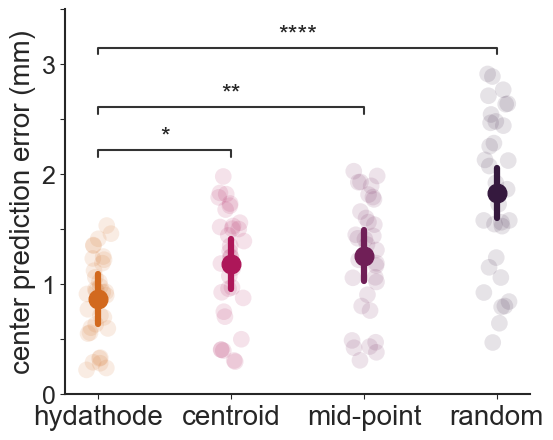

In [79]:
# plotting the subfigure for Voronoi III error:

fig, ax = plt.subplots(figsize = (6,5))

sns.stripplot (x = 'type', y = 'error_mm', data = melted_predict_err_df, order = order, 
               palette = palette,
               alpha = .12, size = 12, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_predict_err_df, x= 'type', y= 'error_mm', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 18)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(pred_results)['mean']['Intercept'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[centroid]'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[mid-point]'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 4.5)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 180, zorder = 2)

    
# ax.set_title('Voronoi I: angle test (n = 34)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 20)
ax.set_xlabel(None)
ax.set_ylabel('center prediction error (mm)', fontsize = 20)
ax.set_yticks([0, .5, 1, 1.5, 2, 2.5, 3, 3.5])
ax.set_yticklabels(labels = [0, None, 1, None, 2, None, 3, None], fontsize = 18)


# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.setp(ax.spines.values(), linewidth=1.5)

plt.show()

